**This notebook is for:**
1. Testing causalML.
https://antonsruberts.github.io/causalml-test/

In [1]:
import sys, os 
prj_path = os.path.dirname(os.getcwd())
utils_path = prj_path + '/utils'
if  not utils_path in sys.path:
    print('adding utils to path ')
    sys.path.insert(1, utils_path)

adding utils to path 


In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    average_precision_score, roc_auc_score, roc_curve, auc, plot_roc_curve, RocCurveDisplay,
    recall_score, f1_score, mean_absolute_percentage_error,r2_score,average_precision_score,
    brier_score_loss
)

import lightgbm as lgbm
from sklift.metrics import qini_auc_score, uplift_auc_score
from sklift.models import  ClassTransformation
from skopt.space import Space
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from sklift.viz import plot_uplift_by_percentile, plot_qini_curve, plot_uplift_curve

from skopt import gp_minimize
# for the analysis
from skopt.plots import (
    plot_convergence,
    plot_evaluations,
    plot_objective
)

from catboost import CatBoostClassifier

from utilities import *
from user_model_evaluation import *

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#Load config.
files = glob.glob(f"{utils_path}/*.yml") 
conf = load_conf(files)

In [3]:
master = pd.read_parquet('MASTER/202203221434.parquet')

In [4]:
#model vars
treatment_var = 'W'
target_var = 'Y'
TARGET = 'TARGET'
exclude_vars = ['CUS_CUST_ID', 'SENT_DATE'] + [treatment_var] + [target_var] + [TARGET]
model_vars = list(set(master.columns) - set(exclude_vars))

In [5]:
def TransformTarget(y:list, treatment:list):
    return (np.array(y) == np.array(treatment)).astype(int)

def p2uplift(p:list):
    return 2*p-1

In [6]:
def check_units(treatment):
    x = np.bincount(treatment)
    return x[0]==x[1]

In [7]:
# master['TARGET'] = TransformTarget(y = master[target_var].tolist(), treatment = master[treatment_var].tolist())
master['CANARY_VAR'] = np.random.uniform(size = master.shape[0])

In [8]:
chk = check_units(master[treatment_var].tolist())
if not chk:
    logger.info(f'Oversmapling for equal probability P(W=1)=P(W=0)')
    # For ClassTransformation approach its necesary that P(W=1)=P(W=0) This implies that 
    # we have the same number of users in the two groups.
    ros = RandomOverSampler(random_state=0)
#     v = model_vars + [treatment_var] + [target_var] + [TARGET]
    v = model_vars + [treatment_var] + [target_var]
    X_oversampled, _ = ros.fit_resample(master[v], master[treatment_var])

2022-03-29 08:24:16 Oversmapling for equal probability P(W=1)=P(W=0)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_oversampled[model_vars + [treatment_var]],
                                                    X_oversampled[target_var],
                                                    random_state= 142,
                                                    shuffle=True,
                                                    stratify = X_oversampled[target_var],
                                                    test_size=0.33)

test_treatment = X_test[treatment_var]

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  random_state= 142,
                                                  shuffle=True,
                                                  stratify = y_train,
                                                  test_size=0.33)

train_treatment = X_train[treatment_var]
val_treatment = X_val[treatment_var]

X_train.drop(labels=treatment_var, axis = 1, inplace = True)
X_test.drop(labels=treatment_var, axis = 1, inplace = True)
X_val.drop(labels=treatment_var, axis = 1, inplace = True)

In [41]:
#List of search space dimensions
callbacks = [lgbm.early_stopping(stopping_rounds=10, first_metric_only=False),
                lgbm.log_evaluation(period=25)]
param_grid = [
    Integer(5,500,prior="uniform",name="n_estimators"),
    Real(10**-4, 10**3, "uniform", name='reg_alpha'),
    Real(10**-4, 10**0, "log-uniform", name='learning_rate'),
    Real(0.1,0.9,prior="uniform",name="feature_fraction"),
    Real(0.1,0.9,prior="uniform",name="bagging_fraction"),
    Integer(2,500,prior="uniform",name="num_leaves") , 
    Integer(2,60,prior="uniform",name="min_child_weight")
]

def auc_pr(y_true, y_pred):
    return 'auc_pr', average_precision_score(y_true, y_pred),True

def brier_score(y_true, y_pred):
    return 'brier',brier_score_loss(y_true, y_pred),False

model_lgbm=lgbm.LGBMClassifier(random_state=9001,
                               importance_type='gain',
                               is_unbalance = True,
                               objective="binary")


In [44]:
@use_named_args(param_grid)
def objective(**params):
     
    # model with new parameters
    logger.info(f"[TRAIN_MODEL] Training model") 
    logger.info(f'Set of params....., {params}')
    
    model_lgbm.set_params(**params)
    classTrans = ClassTransformation(estimator = model_lgbm)
    
    cv = StratifiedKFold(n_splits=3, shuffle=True,random_state=1)
    cv_value = []
    for train_index, test_index in cv.split(X_train,y_train):
        classTrans.fit(X = X_train.iloc[train_index],
                       y = y_train.iloc[train_index],
                       treatment = train_treatment.iloc[train_index],
                       estimator_fit_params={'eval_set':[(X_val,y_val)],
                                             'callbacks' : callbacks,
                                             'eval_metric' : brier_score                                             
                                            }
                      )  
                                     
        y = classTrans.predict(X_train.iloc[test_index])
        y_true = y_train.iloc[test_index].values
        treatment = train_treatment.iloc[test_index].values
        q = qini_auc_score(y_true = y_true, 
                             uplift = y,
                             treatment = treatment,
                            )

        cv_value.append(q)
    del classTrans
    value = np.mean(cv_value)  

    logger.info(f"mean cv_value {value} | std cv_value {np.std(cv_value)} ")
    logger.info("---------------------------------------------")
    return -1*value

In [45]:
gp_ = gp_minimize(
    objective, # the objective function to minimize
    param_grid, # the hyperparameter space
    n_initial_points=25, # the number of points to evaluate f(x) to start of
    acq_func='gp_hedge', # the acquisition function
    n_calls=100, # the number of subsequent evaluations of f(x)
    random_state=10,
    n_jobs=-1,
    verbose=True
)

2022-03-29 09:36:01 [TRAIN_MODEL] Training model
2022-03-29 09:36:01 Set of params....., {'n_estimators': 153, 'reg_alpha': 494.5899800743713, 'learning_rate': 0.00591643082024189, 'feature_fraction': 0.765529087176961, 'bagging_fraction': 0.5666573895501891, 'num_leaves': 15, 'min_child_weight': 43}


Iteration No: 1 started. Evaluating function at random point.
[25]	valid_0's binary_logloss: 0.698476	valid_0's brier: 0.252664
[50]	valid_0's binary_logloss: 0.697963	valid_0's brier: 0.252408
[75]	valid_0's binary_logloss: 0.697566	valid_0's brier: 0.252209
[100]	valid_0's binary_logloss: 0.697213	valid_0's brier: 0.252033
[125]	valid_0's binary_logloss: 0.696819	valid_0's brier: 0.251836
[150]	valid_0's binary_logloss: 0.696497	valid_0's brier: 0.251675
Did not meet early stopping. Best iteration is:
[153]	valid_0's binary_logloss: 0.695506	valid_0's brier: 0.251179
[LightGBM] [Warning] feature_fraction is set=0.765529087176961, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.765529087176961
[LightGBM] [Warning] bagging_fraction is set=0.5666573895501891, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5666573895501891
[25]	valid_0's binary_logloss: 0.697637	valid_0's brier: 0.252245
[50]	valid_0's binary_logloss: 0.697109	valid_0's brier: 0.

2022-03-29 09:36:16 mean cv_value 0.013359526873037403 | std cv_value 0.02099953112384779 
2022-03-29 09:36:16 ---------------------------------------------
2022-03-29 09:36:16 [TRAIN_MODEL] Training model
2022-03-29 09:36:16 Set of params....., {'n_estimators': 136, 'reg_alpha': 263.60291966866777, 'learning_rate': 0.0003994951112183678, 'feature_fraction': 0.6470547434889874, 'bagging_fraction': 0.7532814681765335, 'num_leaves': 169, 'min_child_weight': 54}


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 15.7936
Function value obtained: -0.0134
Current minimum: -0.0134
Iteration No: 2 started. Evaluating function at random point.
[LightGBM] [Warning] feature_fraction is set=0.6470547434889874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6470547434889874
[LightGBM] [Warning] bagging_fraction is set=0.7532814681765335, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7532814681765335
[25]	valid_0's binary_logloss: 0.699014	valid_0's brier: 0.252934
[50]	valid_0's binary_logloss: 0.698966	valid_0's brier: 0.25291
[75]	valid_0's binary_logloss: 0.698918	valid_0's brier: 0.252885
[100]	valid_0's binary_logloss: 0.698867	valid_0's brier: 0.25286
[125]	valid_0's binary_logloss: 0.698822	valid_0's brier: 0.252837
Did not meet early stopping. Best iteration is:
[153]	valid_0's binary_logloss: 0.695506	valid_0's brier: 0.251179
[LightGBM] [Warning] feature_fraction is set=0.64705474348

2022-03-29 09:36:30 mean cv_value 0.020396599088433942 | std cv_value 0.01971606857101904 
2022-03-29 09:36:30 ---------------------------------------------
2022-03-29 09:36:30 [TRAIN_MODEL] Training model
2022-03-29 09:36:30 Set of params....., {'n_estimators': 103, 'reg_alpha': 30.61675081102803, 'learning_rate': 0.3239364060784671, 'feature_fraction': 0.6819484109745868, 'bagging_fraction': 0.5327047450219142, 'num_leaves': 67, 'min_child_weight': 26}


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 13.9971
Function value obtained: -0.0204
Current minimum: -0.0204
Iteration No: 3 started. Evaluating function at random point.
[LightGBM] [Warning] feature_fraction is set=0.6819484109745868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6819484109745868
[LightGBM] [Warning] bagging_fraction is set=0.5327047450219142, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5327047450219142
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.694694	valid_0's brier: 0.250764
[LightGBM] [Warning] feature_fraction is set=0.6819484109745868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6819484109745868
[LightGBM] [Warning] bagging_fraction is set=0.5327047450219142, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5327047450219142
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.694256	valid_0's brier: 0.250542


2022-03-29 09:36:35 mean cv_value 0.04848117751774756 | std cv_value 0.0040632991467557805 
2022-03-29 09:36:35 ---------------------------------------------
2022-03-29 09:36:35 [TRAIN_MODEL] Training model
2022-03-29 09:36:35 Set of params....., {'n_estimators': 390, 'reg_alpha': 583.9014072635395, 'learning_rate': 0.0005376823062708374, 'feature_fraction': 0.7608657981992604, 'bagging_fraction': 0.1843214667902409, 'num_leaves': 143, 'min_child_weight': 6}


Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.694256	valid_0's brier: 0.250542
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 4.5965
Function value obtained: -0.0485
Current minimum: -0.0485
Iteration No: 4 started. Evaluating function at random point.
[LightGBM] [Warning] feature_fraction is set=0.7608657981992604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7608657981992604
[LightGBM] [Warning] bagging_fraction is set=0.1843214667902409, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1843214667902409
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.694256	valid_0's brier: 0.250542
[LightGBM] [Warning] feature_fraction is set=0.7608657981992604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7608657981992604
[LightGBM] [Warning] bagging_fraction is set=0.1843214667902409, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1843214667902409
E

2022-03-29 09:36:39 mean cv_value 0.0244181949879294 | std cv_value 0.025741593667616476 
2022-03-29 09:36:39 ---------------------------------------------
2022-03-29 09:36:39 [TRAIN_MODEL] Training model
2022-03-29 09:36:39 Set of params....., {'n_estimators': 33, 'reg_alpha': 765.4558416696037, 'learning_rate': 0.00011146848987452159, 'feature_fraction': 0.5895546728888088, 'bagging_fraction': 0.3655058045341736, 'num_leaves': 281, 'min_child_weight': 21}


Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.694256	valid_0's brier: 0.250542
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 3.7440
Function value obtained: -0.0244
Current minimum: -0.0485
Iteration No: 5 started. Evaluating function at random point.
[LightGBM] [Warning] feature_fraction is set=0.5895546728888088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5895546728888088
[LightGBM] [Warning] bagging_fraction is set=0.3655058045341736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3655058045341736
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.694256	valid_0's brier: 0.250542
[LightGBM] [Warning] feature_fraction is set=0.5895546728888088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5895546728888088
[LightGBM] [Warning] bagging_fraction is set=0.3655058045341736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3655058045341736
E

2022-03-29 09:36:43 mean cv_value 0.021604247690437756 | std cv_value 0.025230608388883715 
2022-03-29 09:36:43 ---------------------------------------------
2022-03-29 09:36:43 [TRAIN_MODEL] Training model
2022-03-29 09:36:43 Set of params....., {'n_estimators': 209, 'reg_alpha': 76.85559406069696, 'learning_rate': 0.25832828531267416, 'feature_fraction': 0.45198996440343364, 'bagging_fraction': 0.197563317701734, 'num_leaves': 366, 'min_child_weight': 10}


Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.694256	valid_0's brier: 0.250542
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 3.9699
Function value obtained: -0.0216
Current minimum: -0.0485
Iteration No: 6 started. Evaluating function at random point.
[LightGBM] [Warning] feature_fraction is set=0.45198996440343364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45198996440343364
[LightGBM] [Warning] bagging_fraction is set=0.197563317701734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.197563317701734
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.694256	valid_0's brier: 0.250542
[LightGBM] [Warning] feature_fraction is set=0.45198996440343364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45198996440343364
[LightGBM] [Warning] bagging_fraction is set=0.197563317701734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.197563317701734
E

2022-03-29 09:36:48 mean cv_value 0.044072278646748085 | std cv_value 0.012886789047585707 
2022-03-29 09:36:48 ---------------------------------------------
2022-03-29 09:36:48 [TRAIN_MODEL] Training model
2022-03-29 09:36:48 Set of params....., {'n_estimators': 385, 'reg_alpha': 831.989784588276, 'learning_rate': 0.0017342520671971852, 'feature_fraction': 0.5780658322332007, 'bagging_fraction': 0.7979139678712874, 'num_leaves': 492, 'min_child_weight': 29}


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 5.2541
Function value obtained: -0.0441
Current minimum: -0.0485
Iteration No: 7 started. Evaluating function at random point.
[LightGBM] [Warning] feature_fraction is set=0.5780658322332007, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5780658322332007
[LightGBM] [Warning] bagging_fraction is set=0.7979139678712874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7979139678712874
[25]	valid_0's binary_logloss: 0.6989	valid_0's brier: 0.252876
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.694042	valid_0's brier: 0.250435
[LightGBM] [Warning] feature_fraction is set=0.5780658322332007, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5780658322332007
[LightGBM] [Warning] bagging_fraction is set=0.7979139678712874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7979139678712874
[25]	valid_0's binary_logloss: 0.69811

2022-03-29 09:36:52 mean cv_value 0.02538440414262512 | std cv_value 0.026059986192512 
2022-03-29 09:36:52 ---------------------------------------------
2022-03-29 09:36:52 [TRAIN_MODEL] Training model
2022-03-29 09:36:52 Set of params....., {'n_estimators': 438, 'reg_alpha': 296.06876925726505, 'learning_rate': 0.000335092117148988, 'feature_fraction': 0.7742543467947963, 'bagging_fraction': 0.6272290431506303, 'num_leaves': 299, 'min_child_weight': 27}


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 4.2987
Function value obtained: -0.0254
Current minimum: -0.0485
Iteration No: 8 started. Evaluating function at random point.
[LightGBM] [Warning] feature_fraction is set=0.7742543467947963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7742543467947963
[LightGBM] [Warning] bagging_fraction is set=0.6272290431506303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6272290431506303
[25]	valid_0's binary_logloss: 0.699024	valid_0's brier: 0.252938
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.694042	valid_0's brier: 0.250435
[LightGBM] [Warning] feature_fraction is set=0.7742543467947963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7742543467947963
[LightGBM] [Warning] bagging_fraction is set=0.6272290431506303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6272290431506303
[25]	valid_0's binary_logloss: 0.698

2022-03-29 09:36:57 mean cv_value 0.017208874717519022 | std cv_value 0.02339513264142197 
2022-03-29 09:36:57 ---------------------------------------------
2022-03-29 09:36:57 [TRAIN_MODEL] Training model
2022-03-29 09:36:57 Set of params....., {'n_estimators': 181, 'reg_alpha': 587.1309665408564, 'learning_rate': 0.0003961734322015519, 'feature_fraction': 0.2369908785663345, 'bagging_fraction': 0.41773161830205774, 'num_leaves': 320, 'min_child_weight': 24}


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 4.9315
Function value obtained: -0.0172
Current minimum: -0.0485
Iteration No: 9 started. Evaluating function at random point.
[LightGBM] [Warning] feature_fraction is set=0.2369908785663345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2369908785663345
[LightGBM] [Warning] bagging_fraction is set=0.41773161830205774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41773161830205774
[25]	valid_0's binary_logloss: 0.699024	valid_0's brier: 0.252938
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.694042	valid_0's brier: 0.250435
[LightGBM] [Warning] feature_fraction is set=0.2369908785663345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2369908785663345
[LightGBM] [Warning] bagging_fraction is set=0.41773161830205774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41773161830205774
[25]	valid_0's binary_logloss: 0

2022-03-29 09:37:02 mean cv_value 0.03890148506936426 | std cv_value 0.01376145484113548 
2022-03-29 09:37:02 ---------------------------------------------
2022-03-29 09:37:02 [TRAIN_MODEL] Training model
2022-03-29 09:37:02 Set of params....., {'n_estimators': 6, 'reg_alpha': 548.8164008622329, 'learning_rate': 0.00032202335160074613, 'feature_fraction': 0.1638341445056195, 'bagging_fraction': 0.28803087670039723, 'num_leaves': 331, 'min_child_weight': 14}


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 4.6619
Function value obtained: -0.0389
Current minimum: -0.0485
Iteration No: 10 started. Evaluating function at random point.
[LightGBM] [Warning] feature_fraction is set=0.1638341445056195, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1638341445056195
[LightGBM] [Warning] bagging_fraction is set=0.28803087670039723, subsample=1.0 will be ignored. Current value: bagging_fraction=0.28803087670039723
Did not meet early stopping. Best iteration is:
[18]	valid_0's binary_logloss: 0.694042	valid_0's brier: 0.250435
[LightGBM] [Warning] feature_fraction is set=0.1638341445056195, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1638341445056195
[LightGBM] [Warning] bagging_fraction is set=0.28803087670039723, subsample=1.0 will be ignored. Current value: bagging_fraction=0.28803087670039723
Did not meet early stopping. Best iteration is:
[18]	valid_0's binary_logloss: 0.694

2022-03-29 09:37:05 mean cv_value 0.03825993581520504 | std cv_value 0.0121719216473337 
2022-03-29 09:37:05 ---------------------------------------------
2022-03-29 09:37:05 [TRAIN_MODEL] Training model
2022-03-29 09:37:05 Set of params....., {'n_estimators': 106, 'reg_alpha': 382.86517260947187, 'learning_rate': 0.0007933981982342907, 'feature_fraction': 0.19171903935877765, 'bagging_fraction': 0.5664136412328324, 'num_leaves': 118, 'min_child_weight': 34}


Did not meet early stopping. Best iteration is:
[18]	valid_0's binary_logloss: 0.694042	valid_0's brier: 0.250435
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 2.8564
Function value obtained: -0.0383
Current minimum: -0.0485
Iteration No: 11 started. Evaluating function at random point.
[LightGBM] [Warning] feature_fraction is set=0.19171903935877765, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19171903935877765
[LightGBM] [Warning] bagging_fraction is set=0.5664136412328324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5664136412328324
[25]	valid_0's binary_logloss: 0.698972	valid_0's brier: 0.252912
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.694042	valid_0's brier: 0.250435
[LightGBM] [Warning] feature_fraction is set=0.19171903935877765, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19171903935877765
[LightGBM] [Warning] bagging_fraction is set=0.5664136412328324

2022-03-29 09:37:09 mean cv_value 0.039142903791556716 | std cv_value 0.002580502849492287 
2022-03-29 09:37:09 ---------------------------------------------
2022-03-29 09:37:09 [TRAIN_MODEL] Training model
2022-03-29 09:37:09 Set of params....., {'n_estimators': 264, 'reg_alpha': 350.9582886755496, 'learning_rate': 0.06627144690661528, 'feature_fraction': 0.7565629930106799, 'bagging_fraction': 0.20765040277145297, 'num_leaves': 303, 'min_child_weight': 18}


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 4.3035
Function value obtained: -0.0391
Current minimum: -0.0485
Iteration No: 12 started. Evaluating function at random point.
[LightGBM] [Warning] feature_fraction is set=0.7565629930106799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7565629930106799
[LightGBM] [Warning] bagging_fraction is set=0.20765040277145297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20765040277145297
[25]	valid_0's binary_logloss: 0.695176	valid_0's brier: 0.251014
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.694042	valid_0's brier: 0.250435
[LightGBM] [Warning] feature_fraction is set=0.7565629930106799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7565629930106799
[LightGBM] [Warning] bagging_fraction is set=0.20765040277145297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20765040277145297
[25]	valid_0's binary_logloss:

2022-03-29 09:37:14 mean cv_value 0.017718531147718836 | std cv_value 0.016483755339757343 
2022-03-29 09:37:14 ---------------------------------------------
2022-03-29 09:37:14 [TRAIN_MODEL] Training model
2022-03-29 09:37:14 Set of params....., {'n_estimators': 256, 'reg_alpha': 38.46052444449238, 'learning_rate': 0.0021368615456752865, 'feature_fraction': 0.10021802519308434, 'bagging_fraction': 0.631724372896594, 'num_leaves': 190, 'min_child_weight': 45}


[50]	valid_0's binary_logloss: 0.693457	valid_0's brier: 0.250153
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.693293	valid_0's brier: 0.250072
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 5.5433
Function value obtained: -0.0177
Current minimum: -0.0485
Iteration No: 13 started. Evaluating function at random point.
[LightGBM] [Warning] feature_fraction is set=0.10021802519308434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10021802519308434
[LightGBM] [Warning] bagging_fraction is set=0.631724372896594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.631724372896594
[25]	valid_0's binary_logloss: 0.698779	valid_0's brier: 0.252816
[50]	valid_0's binary_logloss: 0.698508	valid_0's brier: 0.25268
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.693293	valid_0's brier: 0.250072
[LightGBM] [Warning] feature_fraction is set=0.10021802519308434, colsample_bytree=1.0 will be ignored.

2022-03-29 09:37:21 mean cv_value 0.06566265736997474 | std cv_value 0.008994390867692577 
2022-03-29 09:37:21 ---------------------------------------------
2022-03-29 09:37:21 [TRAIN_MODEL] Training model
2022-03-29 09:37:21 Set of params....., {'n_estimators': 75, 'reg_alpha': 388.049514534178, 'learning_rate': 0.2923927248963542, 'feature_fraction': 0.8654826610985319, 'bagging_fraction': 0.4892429350440546, 'num_leaves': 55, 'min_child_weight': 22}


Iteration No: 13 ended. Evaluation done at random point.
Time taken: 6.9166
Function value obtained: -0.0657
Current minimum: -0.0657
Iteration No: 14 started. Evaluating function at random point.
[LightGBM] [Warning] feature_fraction is set=0.8654826610985319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8654826610985319
[LightGBM] [Warning] bagging_fraction is set=0.4892429350440546, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4892429350440546
[25]	valid_0's binary_logloss: 0.693754	valid_0's brier: 0.250302
[50]	valid_0's binary_logloss: 0.693752	valid_0's brier: 0.250301
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.693293	valid_0's brier: 0.250072
[LightGBM] [Warning] feature_fraction is set=0.8654826610985319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8654826610985319
[LightGBM] [Warning] bagging_fraction is set=0.4892429350440546, subsample=1.0 will be ignored. Current value: bagg

2022-03-29 09:37:27 mean cv_value 0.01805317536998184 | std cv_value 0.013394783534615208 
2022-03-29 09:37:27 ---------------------------------------------
2022-03-29 09:37:27 [TRAIN_MODEL] Training model
2022-03-29 09:37:27 Set of params....., {'n_estimators': 419, 'reg_alpha': 465.4416796032897, 'learning_rate': 0.000235193021897844, 'feature_fraction': 0.7837553147560197, 'bagging_fraction': 0.3698065487416434, 'num_leaves': 304, 'min_child_weight': 9}


[50]	valid_0's binary_logloss: 0.693438	valid_0's brier: 0.250145
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.693293	valid_0's brier: 0.250072
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 5.3718
Function value obtained: -0.0181
Current minimum: -0.0657
Iteration No: 15 started. Evaluating function at random point.
[LightGBM] [Warning] feature_fraction is set=0.7837553147560197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7837553147560197
[LightGBM] [Warning] bagging_fraction is set=0.3698065487416434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3698065487416434
[25]	valid_0's binary_logloss: 0.699038	valid_0's brier: 0.252945
[50]	valid_0's binary_logloss: 0.699012	valid_0's brier: 0.252933
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.693293	valid_0's brier: 0.250072
[LightGBM] [Warning] feature_fraction is set=0.7837553147560197, colsample_bytree=1.0 will be ignored.

2022-03-29 09:37:33 mean cv_value 0.015061702603629717 | std cv_value 0.027504085191302912 
2022-03-29 09:37:33 ---------------------------------------------
2022-03-29 09:37:33 [TRAIN_MODEL] Training model
2022-03-29 09:37:33 Set of params....., {'n_estimators': 274, 'reg_alpha': 720.7986100351245, 'learning_rate': 0.2905771539381412, 'feature_fraction': 0.21736089922899418, 'bagging_fraction': 0.18270485579806492, 'num_leaves': 246, 'min_child_weight': 4}


[50]	valid_0's binary_logloss: 0.699078	valid_0's brier: 0.252966
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.693293	valid_0's brier: 0.250072
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 5.8895
Function value obtained: -0.0151
Current minimum: -0.0657
Iteration No: 16 started. Evaluating function at random point.
[LightGBM] [Warning] feature_fraction is set=0.21736089922899418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21736089922899418
[LightGBM] [Warning] bagging_fraction is set=0.18270485579806492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.18270485579806492
[25]	valid_0's binary_logloss: 0.693983	valid_0's brier: 0.250418
[50]	valid_0's binary_logloss: 0.693695	valid_0's brier: 0.250274
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.693293	valid_0's brier: 0.250072
[LightGBM] [Warning] feature_fraction is set=0.21736089922899418, colsample_bytree=1.0 will be ign

2022-03-29 09:37:38 mean cv_value 0.008747079764346717 | std cv_value 0.01980466459251221 
2022-03-29 09:37:38 ---------------------------------------------
2022-03-29 09:37:38 [TRAIN_MODEL] Training model
2022-03-29 09:37:38 Set of params....., {'n_estimators': 299, 'reg_alpha': 205.84555498837884, 'learning_rate': 0.0006474584363693109, 'feature_fraction': 0.7753007001165378, 'bagging_fraction': 0.1492531012231279, 'num_leaves': 251, 'min_child_weight': 16}


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 5.3997
Function value obtained: -0.0087
Current minimum: -0.0657
Iteration No: 17 started. Evaluating function at random point.
[LightGBM] [Warning] feature_fraction is set=0.7753007001165378, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7753007001165378
[LightGBM] [Warning] bagging_fraction is set=0.1492531012231279, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1492531012231279
[25]	valid_0's binary_logloss: 0.69898	valid_0's brier: 0.252917
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
[LightGBM] [Warning] feature_fraction is set=0.7753007001165378, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7753007001165378
[LightGBM] [Warning] bagging_fraction is set=0.1492531012231279, subsample=1.0 wi

2022-03-29 09:37:44 mean cv_value 0.02474147576224492 | std cv_value 0.017739285348665906 
2022-03-29 09:37:44 ---------------------------------------------
2022-03-29 09:37:44 [TRAIN_MODEL] Training model
2022-03-29 09:37:44 Set of params....., {'n_estimators': 167, 'reg_alpha': 2.916188054754532, 'learning_rate': 0.0015197373593248626, 'feature_fraction': 0.8895112976110177, 'bagging_fraction': 0.2906661717282849, 'num_leaves': 367, 'min_child_weight': 58}


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 6.2686
Function value obtained: -0.0247
Current minimum: -0.0657
Iteration No: 18 started. Evaluating function at random point.
[LightGBM] [Warning] feature_fraction is set=0.8895112976110177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8895112976110177
[LightGBM] [Warning] bagging_fraction is set=0.2906661717282849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2906661717282849
[25]	valid_0's binary_logloss: 0.698874	valid_0's brier: 0.252863
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
[LightGBM] [Warning] feature_fraction is set=0.8895112976110177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8895112976110177
[LightGBM] [Warning] bagging_fraction is set=0.2906661717282849, subsample=1.0 w

2022-03-29 09:37:58 mean cv_value 0.07828592993195495 | std cv_value 0.003770724586185114 
2022-03-29 09:37:58 ---------------------------------------------
2022-03-29 09:37:58 [TRAIN_MODEL] Training model
2022-03-29 09:37:58 Set of params....., {'n_estimators': 409, 'reg_alpha': 694.2270081422341, 'learning_rate': 0.0006962807306864052, 'feature_fraction': 0.5142752543009074, 'bagging_fraction': 0.8597359928036246, 'num_leaves': 349, 'min_child_weight': 54}


Iteration No: 18 ended. Evaluation done at random point.
Time taken: 13.3856
Function value obtained: -0.0783
Current minimum: -0.0783
Iteration No: 19 started. Evaluating function at random point.
[LightGBM] [Warning] feature_fraction is set=0.5142752543009074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5142752543009074
[LightGBM] [Warning] bagging_fraction is set=0.8597359928036246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8597359928036246
[25]	valid_0's binary_logloss: 0.698986	valid_0's brier: 0.252919
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
[LightGBM] [Warning] feature_fraction is set=0.5142752543009074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5142752543009074
[LightGBM] [Warning] bagging_fraction is set=0.8597359928036246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8597359928036246
[25]	valid_0's binary_logloss: 0.

2022-03-29 09:38:04 mean cv_value 0.0259872990688101 | std cv_value 0.023967049183940683 
2022-03-29 09:38:04 ---------------------------------------------
2022-03-29 09:38:04 [TRAIN_MODEL] Training model
2022-03-29 09:38:04 Set of params....., {'n_estimators': 326, 'reg_alpha': 345.3022145670852, 'learning_rate': 0.00018280641353192654, 'feature_fraction': 0.27650229056758224, 'bagging_fraction': 0.20989859709060207, 'num_leaves': 373, 'min_child_weight': 22}


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 6.5831
Function value obtained: -0.0260
Current minimum: -0.0783
Iteration No: 20 started. Evaluating function at random point.
[LightGBM] [Warning] feature_fraction is set=0.27650229056758224, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.27650229056758224
[LightGBM] [Warning] bagging_fraction is set=0.20989859709060207, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20989859709060207
[25]	valid_0's binary_logloss: 0.699041	valid_0's brier: 0.252947
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
[LightGBM] [Warning] feature_fraction is set=0.27650229056758224, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.27650229056758224
[LightGBM] [Warning] bagging_fraction is set=0.20989859709060207, subsampl

2022-03-29 09:38:10 mean cv_value 0.039891789107377305 | std cv_value 0.006929264525427027 
2022-03-29 09:38:10 ---------------------------------------------
2022-03-29 09:38:10 [TRAIN_MODEL] Training model
2022-03-29 09:38:10 Set of params....., {'n_estimators': 291, 'reg_alpha': 168.35301908653454, 'learning_rate': 0.00014186877447934672, 'feature_fraction': 0.753741363192772, 'bagging_fraction': 0.7499718827536693, 'num_leaves': 96, 'min_child_weight': 24}


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
Iteration No: 20 ended. Evaluation done at random point.
Time taken: 5.3894
Function value obtained: -0.0399
Current minimum: -0.0783
Iteration No: 21 started. Evaluating function at random point.
[LightGBM] [Warning] feature_fraction is set=0.753741363192772, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.753741363192772
[LightGBM] [Warning] bagging_fraction is set=0.7499718827536693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7499718827536693
[25]	valid_0's binary_logloss: 0.699045	valid_0's brier: 0.252949
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
[LightGBM] [Warning] feature_fraction is set=0.753741363192772, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.753741363192772
[LightGBM] [Warning] bagging_fraction is set=0.7499718827536693, subsample=1.0 will 

2022-03-29 09:38:16 mean cv_value 0.02882350533508608 | std cv_value 0.01754599975345568 
2022-03-29 09:38:16 ---------------------------------------------
2022-03-29 09:38:16 [TRAIN_MODEL] Training model
2022-03-29 09:38:16 Set of params....., {'n_estimators': 373, 'reg_alpha': 186.24785562319485, 'learning_rate': 0.004520549467372137, 'feature_fraction': 0.28480425576092094, 'bagging_fraction': 0.6228983432470478, 'num_leaves': 383, 'min_child_weight': 50}


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
Iteration No: 21 ended. Evaluation done at random point.
Time taken: 6.3278
Function value obtained: -0.0288
Current minimum: -0.0783
Iteration No: 22 started. Evaluating function at random point.
[LightGBM] [Warning] feature_fraction is set=0.28480425576092094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28480425576092094
[LightGBM] [Warning] bagging_fraction is set=0.6228983432470478, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6228983432470478
[25]	valid_0's binary_logloss: 0.698498	valid_0's brier: 0.252675
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
[LightGBM] [Warning] feature_fraction is set=0.28480425576092094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28480425576092094
[LightGBM] [Warning] bagging_fraction is set=0.6228983432470478, subsample=1

2022-03-29 09:38:22 mean cv_value 0.04039582873461571 | std cv_value 0.013763833218496686 
2022-03-29 09:38:22 ---------------------------------------------
2022-03-29 09:38:22 [TRAIN_MODEL] Training model
2022-03-29 09:38:22 Set of params....., {'n_estimators': 110, 'reg_alpha': 961.9666045576485, 'learning_rate': 0.00110805514306556, 'feature_fraction': 0.7910161566621107, 'bagging_fraction': 0.20149953625272662, 'num_leaves': 187, 'min_child_weight': 41}


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
Iteration No: 22 ended. Evaluation done at random point.
Time taken: 6.0453
Function value obtained: -0.0404
Current minimum: -0.0783
Iteration No: 23 started. Evaluating function at random point.
[LightGBM] [Warning] feature_fraction is set=0.7910161566621107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7910161566621107
[LightGBM] [Warning] bagging_fraction is set=0.20149953625272662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20149953625272662
[25]	valid_0's binary_logloss: 0.698975	valid_0's brier: 0.252914
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
[LightGBM] [Warning] feature_fraction is set=0.7910161566621107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7910161566621107
[LightGBM] [Warning] bagging_fraction is set=0.20149953625272662, subsample=1.

2022-03-29 09:38:27 mean cv_value 0.027486730468874735 | std cv_value 0.023724644900433856 
2022-03-29 09:38:27 ---------------------------------------------
2022-03-29 09:38:27 [TRAIN_MODEL] Training model
2022-03-29 09:38:27 Set of params....., {'n_estimators': 467, 'reg_alpha': 558.8995767642205, 'learning_rate': 0.04895493070318753, 'feature_fraction': 0.16164421175298332, 'bagging_fraction': 0.29990898600288396, 'num_leaves': 179, 'min_child_weight': 3}


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 5.1955
Function value obtained: -0.0275
Current minimum: -0.0783
Iteration No: 24 started. Evaluating function at random point.
[LightGBM] [Warning] feature_fraction is set=0.16164421175298332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16164421175298332
[LightGBM] [Warning] bagging_fraction is set=0.29990898600288396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.29990898600288396
[25]	valid_0's binary_logloss: 0.695929	valid_0's brier: 0.251391
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
[LightGBM] [Warning] feature_fraction is set=0.16164421175298332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16164421175298332
[LightGBM] [Warning] bagging_fraction is set=0.29990898600288396, subsampl

2022-03-29 09:38:32 mean cv_value 0.04014709031905068 | std cv_value 0.01227259746125917 
2022-03-29 09:38:32 ---------------------------------------------
2022-03-29 09:38:32 [TRAIN_MODEL] Training model
2022-03-29 09:38:32 Set of params....., {'n_estimators': 468, 'reg_alpha': 209.59779166664737, 'learning_rate': 0.020281119175715925, 'feature_fraction': 0.5648378646562278, 'bagging_fraction': 0.28713692892229925, 'num_leaves': 243, 'min_child_weight': 34}


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 5.1937
Function value obtained: -0.0401
Current minimum: -0.0783
Iteration No: 25 started. Evaluating function at random point.
[LightGBM] [Warning] feature_fraction is set=0.5648378646562278, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5648378646562278
[LightGBM] [Warning] bagging_fraction is set=0.28713692892229925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.28713692892229925
[25]	valid_0's binary_logloss: 0.69702	valid_0's brier: 0.251936
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
[LightGBM] [Warning] feature_fraction is set=0.5648378646562278, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5648378646562278
[LightGBM] [Warning] bagging_fraction is set=0.28713692892229925, subsample=1.0

2022-03-29 09:38:38 mean cv_value 0.02556466387973963 | std cv_value 0.01738276771059197 
2022-03-29 09:38:38 ---------------------------------------------


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029


2022-03-29 09:38:42 [TRAIN_MODEL] Training model
2022-03-29 09:38:42 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 2}


Iteration No: 25 ended. Evaluation done at random point.
Time taken: 9.2440
Function value obtained: -0.0256
Current minimum: -0.0783
Iteration No: 26 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[25]	valid_0's binary_logloss: 0.886997	valid_0's brier: 0.315401
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[25]	valid_0's binary_logloss: 0.886146	valid_0's brier: 0.315273
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's br

2022-03-29 09:38:54 mean cv_value 0.13210448589907256 | std cv_value 0.006343412624469348 
2022-03-29 09:38:54 ---------------------------------------------


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029


2022-03-29 09:38:57 [TRAIN_MODEL] Training model
2022-03-29 09:38:57 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 0.0001, 'feature_fraction': 0.9, 'bagging_fraction': 0.1, 'num_leaves': 2, 'min_child_weight': 60}


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 14.8378
Function value obtained: -0.1321
Current minimum: -0.1321
Iteration No: 27 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[25]	valid_0's binary_logloss: 0.699049	valid_0's brier: 0.252951
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[25]	valid_0's binary_logloss: 0.698257	valid_0's brier: 0.252555
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	

2022-03-29 09:39:02 mean cv_value 0.009063348097234192 | std cv_value 0.018749309637314825 
2022-03-29 09:39:02 ---------------------------------------------


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029


2022-03-29 09:39:04 [TRAIN_MODEL] Training model
2022-03-29 09:39:04 Set of params....., {'n_estimators': 11, 'reg_alpha': 0.0001, 'learning_rate': 0.0001, 'feature_fraction': 0.4480897387818541, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 60}


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 7.2429
Function value obtained: -0.0091
Current minimum: -0.1321
Iteration No: 28 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.4480897387818541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4480897387818541
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Did not meet early stopping. Best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
[LightGBM] [Warning] feature_fraction is set=0.4480897387818541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4480897387818541
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Did not meet early stopping. Best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
[LightGBM] [Warning] 

2022-03-29 09:39:10 mean cv_value 0.10506933037334876 | std cv_value 0.008149691880304457 
2022-03-29 09:39:10 ---------------------------------------------


Did not meet early stopping. Best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029


2022-03-29 09:39:11 [TRAIN_MODEL] Training model
2022-03-29 09:39:11 Set of params....., {'n_estimators': 5, 'reg_alpha': 0.0001, 'learning_rate': 0.0001, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 60}


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 6.7973
Function value obtained: -0.1051
Current minimum: -0.1321
Iteration No: 29 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Did not meet early stopping. Best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Did not meet early stopping. Best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ig

2022-03-29 09:39:14 mean cv_value 0.07422542040814843 | std cv_value 0.005642002191749706 
2022-03-29 09:39:14 ---------------------------------------------


Did not meet early stopping. Best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029


2022-03-29 09:39:15 [TRAIN_MODEL] Training model
2022-03-29 09:39:15 Set of params....., {'n_estimators': 5, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.9, 'bagging_fraction': 0.1, 'num_leaves': 500, 'min_child_weight': 60}


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 4.7985
Function value obtained: -0.0742
Current minimum: -0.1321
Iteration No: 30 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
Did not meet early stopping. Best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
Did not meet early stopping. Best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ig

2022-03-29 09:39:19 mean cv_value 0.10134195827839972 | std cv_value 0.012722678918549512 
2022-03-29 09:39:19 ---------------------------------------------


Did not meet early stopping. Best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029


2022-03-29 09:39:20 [TRAIN_MODEL] Training model
2022-03-29 09:39:20 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 0.1109490489916326, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 60}


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 4.4943
Function value obtained: -0.1013
Current minimum: -0.1321
Iteration No: 31 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[25]	valid_0's binary_logloss: 0.700573	valid_0's brier: 0.25364
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[25]	valid_0's binary_logloss: 0.700744	valid_0's brier: 0.253712
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	va

2022-03-29 09:39:35 mean cv_value 0.1310495375343883 | std cv_value 0.00466482986690142 
2022-03-29 09:39:35 ---------------------------------------------


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029


2022-03-29 09:39:36 [TRAIN_MODEL] Training model
2022-03-29 09:39:36 Set of params....., {'n_estimators': 500, 'reg_alpha': 1000.0, 'learning_rate': 0.0001, 'feature_fraction': 0.1, 'bagging_fraction': 0.9, 'num_leaves': 2, 'min_child_weight': 20}


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 15.7882
Function value obtained: -0.1310
Current minimum: -0.1321
Iteration No: 32 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[25]	valid_0's binary_logloss: 0.699059	valid_0's brier: 0.252956
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[25]	valid_0's binary_logloss: 0.698267	valid_0's brier: 0.25256
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	v

2022-03-29 09:39:41 mean cv_value 0.044191380704317905 | std cv_value 0.0033689338751226915 
2022-03-29 09:39:41 ---------------------------------------------


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029


2022-03-29 09:39:42 [TRAIN_MODEL] Training model
2022-03-29 09:39:42 Set of params....., {'n_estimators': 268, 'reg_alpha': 18.74088835734348, 'learning_rate': 0.46896940467046383, 'feature_fraction': 0.671483989664565, 'bagging_fraction': 0.8619770951118092, 'num_leaves': 484, 'min_child_weight': 30}


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 6.4883
Function value obtained: -0.0442
Current minimum: -0.1321
Iteration No: 33 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.671483989664565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.671483989664565
[LightGBM] [Warning] bagging_fraction is set=0.8619770951118092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8619770951118092
[25]	valid_0's binary_logloss: 0.71822	valid_0's brier: 0.261853
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
[LightGBM] [Warning] feature_fraction is set=0.671483989664565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.671483989664565
[LightGBM] [Warning] bagging_fraction is set=0.8619770951118092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8619770951118092
[25]	valid_0's binary_loglo

2022-03-29 09:39:57 mean cv_value 0.1335942023111469 | std cv_value 0.006916308958712277 
2022-03-29 09:39:57 ---------------------------------------------
2022-03-29 09:39:58 [TRAIN_MODEL] Training model
2022-03-29 09:39:58 Set of params....., {'n_estimators': 98, 'reg_alpha': 0.0001, 'learning_rate': 0.09758548029968969, 'feature_fraction': 0.7034501425563827, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 9}


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 16.0630
Function value obtained: -0.1336
Current minimum: -0.1336
Iteration No: 34 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.7034501425563827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7034501425563827
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[25]	valid_0's binary_logloss: 0.700137	valid_0's brier: 0.253439
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
[LightGBM] [Warning] feature_fraction is set=0.7034501425563827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7034501425563827
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[25]	valid_0's binary_logloss: 0.700071	valid_0's brier: 0.253392
Early stopping,

2022-03-29 09:40:14 mean cv_value 0.140169962614903 | std cv_value 0.004745058018565178 
2022-03-29 09:40:14 ---------------------------------------------


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029


2022-03-29 09:40:15 [TRAIN_MODEL] Training model
2022-03-29 09:40:15 Set of params....., {'n_estimators': 494, 'reg_alpha': 8.829369686200913, 'learning_rate': 0.6305058058385575, 'feature_fraction': 0.10504254730832284, 'bagging_fraction': 0.622132822322482, 'num_leaves': 491, 'min_child_weight': 6}


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 16.6318
Function value obtained: -0.1402
Current minimum: -0.1402
Iteration No: 35 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.10504254730832284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10504254730832284
[LightGBM] [Warning] bagging_fraction is set=0.622132822322482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.622132822322482
[25]	valid_0's binary_logloss: 0.70726	valid_0's brier: 0.25677
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
[LightGBM] [Warning] feature_fraction is set=0.10504254730832284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10504254730832284
[LightGBM] [Warning] bagging_fraction is set=0.622132822322482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.622132822322482
[25]	valid_0's binary_l

2022-03-29 09:40:25 mean cv_value 0.10147140415627277 | std cv_value 0.008565441643162999 
2022-03-29 09:40:25 ---------------------------------------------


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029


2022-03-29 09:40:27 [TRAIN_MODEL] Training model
2022-03-29 09:40:27 Set of params....., {'n_estimators': 270, 'reg_alpha': 12.100299759473286, 'learning_rate': 0.012023357624391318, 'feature_fraction': 0.392407051375114, 'bagging_fraction': 0.8051067511713188, 'num_leaves': 498, 'min_child_weight': 8}


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 11.6723
Function value obtained: -0.1015
Current minimum: -0.1402
Iteration No: 36 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.392407051375114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.392407051375114
[LightGBM] [Warning] bagging_fraction is set=0.8051067511713188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8051067511713188
[25]	valid_0's binary_logloss: 0.697928	valid_0's brier: 0.25239
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
[LightGBM] [Warning] feature_fraction is set=0.392407051375114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.392407051375114
[LightGBM] [Warning] bagging_fraction is set=0.8051067511713188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8051067511713188
[25]	valid_0's binary_logl

2022-03-29 09:40:41 mean cv_value 0.12119933383671581 | std cv_value 0.004072486387207442 
2022-03-29 09:40:41 ---------------------------------------------


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029


2022-03-29 09:40:42 [TRAIN_MODEL] Training model
2022-03-29 09:40:42 Set of params....., {'n_estimators': 482, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.5369433382821812, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 60}


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 15.9457
Function value obtained: -0.1212
Current minimum: -0.1402
Iteration No: 37 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.5369433382821812, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5369433382821812
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[25]	valid_0's binary_logloss: 0.829996	valid_0's brier: 0.30123
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
[LightGBM] [Warning] feature_fraction is set=0.5369433382821812, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5369433382821812
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[25]	valid_0's binary_logloss: 0.828942	valid_0's brier: 0.300537
Early stopping, 

2022-03-29 09:40:58 mean cv_value 0.16040241127888202 | std cv_value 0.01250728726022166 
2022-03-29 09:40:58 ---------------------------------------------
2022-03-29 09:40:59 [TRAIN_MODEL] Training model
2022-03-29 09:40:59 Set of params....., {'n_estimators': 17, 'reg_alpha': 912.849933476437, 'learning_rate': 0.21420893860437717, 'feature_fraction': 0.8733558803880229, 'bagging_fraction': 0.8239710303671088, 'num_leaves': 12, 'min_child_weight': 54}


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 16.4089
Function value obtained: -0.1604
Current minimum: -0.1604
Iteration No: 38 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.8733558803880229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8733558803880229
[LightGBM] [Warning] bagging_fraction is set=0.8239710303671088, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8239710303671088
Did not meet early stopping. Best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
[LightGBM] [Warning] feature_fraction is set=0.8733558803880229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8733558803880229
[LightGBM] [Warning] bagging_fraction is set=0.8239710303671088, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8239710303671088
Did not meet early stopping. Best iteration is:
[33]	valid_0's binary_logl

2022-03-29 09:41:03 mean cv_value 0.014531024637399158 | std cv_value 0.01934149267690502 
2022-03-29 09:41:03 ---------------------------------------------


Did not meet early stopping. Best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029


2022-03-29 09:41:05 [TRAIN_MODEL] Training model
2022-03-29 09:41:05 Set of params....., {'n_estimators': 5, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.4530256139548551, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 60}


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 5.9301
Function value obtained: -0.0145
Current minimum: -0.1604
Iteration No: 39 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.4530256139548551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4530256139548551
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Did not meet early stopping. Best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
[LightGBM] [Warning] feature_fraction is set=0.4530256139548551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4530256139548551
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Did not meet early stopping. Best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
[LightGBM] [Warning] 

2022-03-29 09:41:09 mean cv_value 0.0874367070867083 | std cv_value 0.007928620575284798 
2022-03-29 09:41:09 ---------------------------------------------


Did not meet early stopping. Best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029


2022-03-29 09:41:10 [TRAIN_MODEL] Training model
2022-03-29 09:41:10 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 0.027709794009639927, 'feature_fraction': 0.6182686541144803, 'bagging_fraction': 0.1, 'num_leaves': 500, 'min_child_weight': 2}


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 5.1582
Function value obtained: -0.0874
Current minimum: -0.1604
Iteration No: 40 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.6182686541144803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6182686541144803
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[25]	valid_0's binary_logloss: 0.697571	valid_0's brier: 0.252209
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
[LightGBM] [Warning] feature_fraction is set=0.6182686541144803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6182686541144803
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[25]	valid_0's binary_logloss: 0.697106	valid_0's brier: 0.251976
Early stopping, 

2022-03-29 09:41:25 mean cv_value 0.13007077867408282 | std cv_value 0.007907861855503283 
2022-03-29 09:41:25 ---------------------------------------------
2022-03-29 09:41:26 [TRAIN_MODEL] Training model
2022-03-29 09:41:26 Set of params....., {'n_estimators': 255, 'reg_alpha': 65.19182628174713, 'learning_rate': 0.6270806236755854, 'feature_fraction': 0.11558845334344393, 'bagging_fraction': 0.14223479994625798, 'num_leaves': 4, 'min_child_weight': 56}


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 16.2962
Function value obtained: -0.1301
Current minimum: -0.1604
Iteration No: 41 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.11558845334344393, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11558845334344393
[LightGBM] [Warning] bagging_fraction is set=0.14223479994625798, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14223479994625798
[25]	valid_0's binary_logloss: 0.693703	valid_0's brier: 0.250273
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.693204	valid_0's brier: 0.250029
[LightGBM] [Warning] feature_fraction is set=0.11558845334344393, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11558845334344393
[LightGBM] [Warning] bagging_fraction is set=0.14223479994625798, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14223479994625798
Early stoppin

2022-03-29 09:41:30 mean cv_value 0.03091572796886678 | std cv_value 0.01621216660173597 
2022-03-29 09:41:30 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:41:32 [TRAIN_MODEL] Training model
2022-03-29 09:41:32 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.6104755893891799, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 2}


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 5.3950
Function value obtained: -0.0309
Current minimum: -0.1604
Iteration No: 42 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.6104755893891799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6104755893891799
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.6104755893891799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6104755893891799
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.61

2022-03-29 09:41:39 mean cv_value 0.09490663841732246 | std cv_value 0.006284168749961159 
2022-03-29 09:41:39 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:41:40 [TRAIN_MODEL] Training model
2022-03-29 09:41:40 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 0.00034987401482172053, 'feature_fraction': 0.1, 'bagging_fraction': 0.492715795161332, 'num_leaves': 500, 'min_child_weight': 60}


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 8.3769
Function value obtained: -0.0949
Current minimum: -0.1604
Iteration No: 43 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.492715795161332, subsample=1.0 will be ignored. Current value: bagging_fraction=0.492715795161332
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.492715795161332, subsample=1.0 will be ignored. Current value: bagging_fraction=0.492715795161332
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.1, col

2022-03-29 09:41:45 mean cv_value 0.06941837559341167 | std cv_value 0.0003090551378317835 
2022-03-29 09:41:45 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:41:47 [TRAIN_MODEL] Training model
2022-03-29 09:41:47 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.9, 'bagging_fraction': 0.3662271880615343, 'num_leaves': 500, 'min_child_weight': 60}


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 6.8862
Function value obtained: -0.0694
Current minimum: -0.1604
Iteration No: 44 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.3662271880615343, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3662271880615343
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.3662271880615343, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3662271880615343
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9,

2022-03-29 09:41:54 mean cv_value 0.10614184534058602 | std cv_value 0.014828746982591219 
2022-03-29 09:41:54 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:41:55 [TRAIN_MODEL] Training model
2022-03-29 09:41:55 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.6837228848977748, 'bagging_fraction': 0.8083463995988506, 'num_leaves': 500, 'min_child_weight': 2}


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 8.2216
Function value obtained: -0.1061
Current minimum: -0.1604
Iteration No: 45 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.6837228848977748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6837228848977748
[LightGBM] [Warning] bagging_fraction is set=0.8083463995988506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8083463995988506
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.6837228848977748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6837228848977748
[LightGBM] [Warning] bagging_fraction is set=0.8083463995988506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8083463995988506
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier

2022-03-29 09:42:02 mean cv_value 0.1024625433688907 | std cv_value 0.012881994137087563 
2022-03-29 09:42:02 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:42:04 [TRAIN_MODEL] Training model
2022-03-29 09:42:04 Set of params....., {'n_estimators': 5, 'reg_alpha': 0.0001, 'learning_rate': 0.08052461933584837, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 2}


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 8.6316
Function value obtained: -0.1025
Current minimum: -0.1604
Iteration No: 46 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be igno

2022-03-29 09:42:08 mean cv_value 0.09495425458415667 | std cv_value 0.002780984228345736 
2022-03-29 09:42:08 ---------------------------------------------


Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:42:09 [TRAIN_MODEL] Training model
2022-03-29 09:42:09 Set of params....., {'n_estimators': 417, 'reg_alpha': 396.4902323062694, 'learning_rate': 0.41206607680121604, 'feature_fraction': 0.895410598469541, 'bagging_fraction': 0.24467538291061017, 'num_leaves': 495, 'min_child_weight': 4}


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 5.0531
Function value obtained: -0.0950
Current minimum: -0.1604
Iteration No: 47 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.895410598469541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.895410598469541
[LightGBM] [Warning] bagging_fraction is set=0.24467538291061017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24467538291061017
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.895410598469541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.895410598469541
[LightGBM] [Warning] bagging_fraction is set=0.24467538291061017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24467538291061017
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier

2022-03-29 09:42:12 mean cv_value 0.014843063278970137 | std cv_value 0.008514281319383095 
2022-03-29 09:42:12 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


/usr/local/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
2022-03-29 09:42:13 [TRAIN_MODEL] Training model
2022-03-29 09:42:13 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 2}


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 4.5480
Function value obtained: -0.0148
Current minimum: -0.1604
Iteration No: 48 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featur

2022-03-29 09:42:20 mean cv_value 0.10545629431841204 | std cv_value 0.0143454322842606 
2022-03-29 09:42:20 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:42:22 [TRAIN_MODEL] Training model
2022-03-29 09:42:22 Set of params....., {'n_estimators': 132, 'reg_alpha': 990.9835487938612, 'learning_rate': 0.5173577924524017, 'feature_fraction': 0.1608276681546406, 'bagging_fraction': 0.27369090625205805, 'num_leaves': 459, 'min_child_weight': 24}


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 8.3200
Function value obtained: -0.1055
Current minimum: -0.1604
Iteration No: 49 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.1608276681546406, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1608276681546406
[LightGBM] [Warning] bagging_fraction is set=0.27369090625205805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.27369090625205805
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.1608276681546406, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1608276681546406
[LightGBM] [Warning] bagging_fraction is set=0.27369090625205805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.27369090625205805
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's b

2022-03-29 09:42:25 mean cv_value 0.021686928067495222 | std cv_value 0.024954518072548556 
2022-03-29 09:42:25 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:42:26 [TRAIN_MODEL] Training model
2022-03-29 09:42:26 Set of params....., {'n_estimators': 315, 'reg_alpha': 511.41051338018184, 'learning_rate': 0.5691396550086076, 'feature_fraction': 0.10954874693841142, 'bagging_fraction': 0.8210419924930666, 'num_leaves': 491, 'min_child_weight': 51}


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 4.7679
Function value obtained: -0.0217
Current minimum: -0.1604
Iteration No: 50 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.10954874693841142, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10954874693841142
[LightGBM] [Warning] bagging_fraction is set=0.8210419924930666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8210419924930666
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.10954874693841142, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10954874693841142
[LightGBM] [Warning] bagging_fraction is set=0.8210419924930666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8210419924930666
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's b

2022-03-29 09:42:30 mean cv_value 0.019949036536817722 | std cv_value 0.019111854694327447 
2022-03-29 09:42:30 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:42:31 [TRAIN_MODEL] Training model
2022-03-29 09:42:31 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.1, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 60}


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 5.0094
Function value obtained: -0.0199
Current minimum: -0.1604
Iteration No: 51 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: featur

2022-03-29 09:42:37 mean cv_value 0.06457120478936253 | std cv_value 0.000649340060935085 
2022-03-29 09:42:37 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:42:39 [TRAIN_MODEL] Training model
2022-03-29 09:42:39 Set of params....., {'n_estimators': 425, 'reg_alpha': 992.888635417768, 'learning_rate': 0.0004092900731514313, 'feature_fraction': 0.8934549756976208, 'bagging_fraction': 0.749886529769134, 'num_leaves': 473, 'min_child_weight': 12}


Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 7.4196
Function value obtained: -0.0646
Current minimum: -0.1604
Iteration No: 52 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.8934549756976208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8934549756976208
[LightGBM] [Warning] bagging_fraction is set=0.749886529769134, subsample=1.0 will be ignored. Current value: bagging_fraction=0.749886529769134
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.8934549756976208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8934549756976208
[LightGBM] [Warning] bagging_fraction is set=0.749886529769134, subsample=1.0 will be ignored. Current value: bagging_fraction=0.749886529769134
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.

2022-03-29 09:42:42 mean cv_value 0.016826012869664415 | std cv_value 0.01611677152993602 
2022-03-29 09:42:42 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:42:44 [TRAIN_MODEL] Training model
2022-03-29 09:42:44 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.6840180584507188, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 60}


Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 5.1005
Function value obtained: -0.0168
Current minimum: -0.1604
Iteration No: 53 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.6840180584507188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6840180584507188
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.6840180584507188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6840180584507188
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.68

2022-03-29 09:42:51 mean cv_value 0.1033303616789125 | std cv_value 0.00506521307030764 
2022-03-29 09:42:51 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:42:53 [TRAIN_MODEL] Training model
2022-03-29 09:42:53 Set of params....., {'n_estimators': 435, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.7154696223655511, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 2}


Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 8.7221
Function value obtained: -0.1033
Current minimum: -0.1604
Iteration No: 54 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.7154696223655511, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7154696223655511
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.7154696223655511, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7154696223655511
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.71

2022-03-29 09:42:59 mean cv_value 0.09885382280704125 | std cv_value 0.006104374928472169 
2022-03-29 09:42:59 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:43:01 [TRAIN_MODEL] Training model
2022-03-29 09:43:01 Set of params....., {'n_estimators': 135, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.7557598945851511, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 26}


Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 8.2733
Function value obtained: -0.0989
Current minimum: -0.1604
Iteration No: 55 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.7557598945851511, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7557598945851511
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.7557598945851511, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7557598945851511
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.75

2022-03-29 09:43:09 mean cv_value 0.09567693808274334 | std cv_value 0.006631810914628542 
2022-03-29 09:43:09 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:43:10 [TRAIN_MODEL] Training model
2022-03-29 09:43:10 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.9, 'bagging_fraction': 0.1, 'num_leaves': 500, 'min_child_weight': 60}


Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 8.9638
Function value obtained: -0.0957
Current minimum: -0.1604
Iteration No: 56 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featur

2022-03-29 09:43:17 mean cv_value 0.10614184534058602 | std cv_value 0.014828746982591219 
2022-03-29 09:43:17 ---------------------------------------------
2022-03-29 09:43:19 [TRAIN_MODEL] Training model
2022-03-29 09:43:19 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.689048527937693, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 2}


Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 8.7134
Function value obtained: -0.1061
Current minimum: -0.1604
Iteration No: 57 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.689048527937693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.689048527937693
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.689048527937693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.689048527937693
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.689048

2022-03-29 09:43:25 mean cv_value 0.09885382280704125 | std cv_value 0.006104374928472169 
2022-03-29 09:43:25 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:43:27 [TRAIN_MODEL] Training model
2022-03-29 09:43:27 Set of params....., {'n_estimators': 495, 'reg_alpha': 672.8259170655334, 'learning_rate': 0.00010550339270434579, 'feature_fraction': 0.11276415792344353, 'bagging_fraction': 0.44514791412614263, 'num_leaves': 32, 'min_child_weight': 36}


Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 8.0155
Function value obtained: -0.0989
Current minimum: -0.1604
Iteration No: 58 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.11276415792344353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11276415792344353
[LightGBM] [Warning] bagging_fraction is set=0.44514791412614263, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44514791412614263
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.11276415792344353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11276415792344353
[LightGBM] [Warning] bagging_fraction is set=0.44514791412614263, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44514791412614263
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0

2022-03-29 09:43:30 mean cv_value 0.04505065366038135 | std cv_value 0.0058796766287724875 
2022-03-29 09:43:30 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


/usr/local/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
2022-03-29 09:43:32 [TRAIN_MODEL] Training model
2022-03-29 09:43:32 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 2}


Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 4.9200
Function value obtained: -0.0451
Current minimum: -0.1604
Iteration No: 59 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featur

2022-03-29 09:43:38 mean cv_value 0.10545629431841204 | std cv_value 0.0143454322842606 
2022-03-29 09:43:38 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:43:40 [TRAIN_MODEL] Training model
2022-03-29 09:43:40 Set of params....., {'n_estimators': 123, 'reg_alpha': 961.8182072685246, 'learning_rate': 0.8972414705771241, 'feature_fraction': 0.22117017423716168, 'bagging_fraction': 0.8652766853281395, 'num_leaves': 2, 'min_child_weight': 7}


Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 8.0482
Function value obtained: -0.1055
Current minimum: -0.1604
Iteration No: 60 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.22117017423716168, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22117017423716168
[LightGBM] [Warning] bagging_fraction is set=0.8652766853281395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8652766853281395
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.22117017423716168, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22117017423716168
[LightGBM] [Warning] bagging_fraction is set=0.8652766853281395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8652766853281395
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's b

2022-03-29 09:43:43 mean cv_value 0.02027523903239142 | std cv_value 0.022176721463925016 
2022-03-29 09:43:43 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:43:44 [TRAIN_MODEL] Training model
2022-03-29 09:43:44 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.719179399832087, 'bagging_fraction': 0.5697980346395419, 'num_leaves': 500, 'min_child_weight': 60}


Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 4.6167
Function value obtained: -0.0203
Current minimum: -0.1604
Iteration No: 61 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.719179399832087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.719179399832087
[LightGBM] [Warning] bagging_fraction is set=0.5697980346395419, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5697980346395419
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.719179399832087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.719179399832087
[LightGBM] [Warning] bagging_fraction is set=0.5697980346395419, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5697980346395419
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.

2022-03-29 09:43:51 mean cv_value 0.11622788344703383 | std cv_value 0.01100538837826834 
2022-03-29 09:43:51 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:43:53 [TRAIN_MODEL] Training model
2022-03-29 09:43:53 Set of params....., {'n_estimators': 242, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.6850923230818929, 'bagging_fraction': 0.5878480254082888, 'num_leaves': 500, 'min_child_weight': 60}


Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 8.6651
Function value obtained: -0.1162
Current minimum: -0.1604
Iteration No: 62 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.6850923230818929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6850923230818929
[LightGBM] [Warning] bagging_fraction is set=0.5878480254082888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5878480254082888
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.6850923230818929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6850923230818929
[LightGBM] [Warning] bagging_fraction is set=0.5878480254082888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5878480254082888
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier

2022-03-29 09:44:00 mean cv_value 0.1033303616789125 | std cv_value 0.00506521307030764 
2022-03-29 09:44:00 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:44:02 [TRAIN_MODEL] Training model
2022-03-29 09:44:02 Set of params....., {'n_estimators': 5, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.9, 'bagging_fraction': 0.5068379508450102, 'num_leaves': 500, 'min_child_weight': 60}


Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 9.0283
Function value obtained: -0.1033
Current minimum: -0.1604
Iteration No: 63 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5068379508450102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5068379508450102
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5068379508450102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5068379508450102
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] fe

2022-03-29 09:44:06 mean cv_value 0.10134195827839972 | std cv_value 0.012722678918549512 
2022-03-29 09:44:06 ---------------------------------------------


Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:44:07 [TRAIN_MODEL] Training model
2022-03-29 09:44:07 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 0.029706857471050122, 'feature_fraction': 0.6618821318578465, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 2}


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 5.4580
Function value obtained: -0.1013
Current minimum: -0.1604
Iteration No: 64 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.6618821318578465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6618821318578465
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.6618821318578465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6618821318578465
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.66

2022-03-29 09:44:15 mean cv_value 0.09501912327482913 | std cv_value 0.007380062499266964 


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:44:15 ---------------------------------------------
/usr/local/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
2022-03-29 09:44:17 [TRAIN_MODEL] Training model
2022-03-29 09:44:17 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 2}


Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 9.0785
Function value obtained: -0.0950
Current minimum: -0.1604
Iteration No: 65 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featur

2022-03-29 09:44:23 mean cv_value 0.10545629431841204 | std cv_value 0.0143454322842606 
2022-03-29 09:44:23 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:44:24 [TRAIN_MODEL] Training model
2022-03-29 09:44:24 Set of params....., {'n_estimators': 5, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.6643132641154608, 'bagging_fraction': 0.1, 'num_leaves': 500, 'min_child_weight': 2}


Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 7.8557
Function value obtained: -0.1055
Current minimum: -0.1604
Iteration No: 66 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.6643132641154608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6643132641154608
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.6643132641154608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6643132641154608
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] fe

2022-03-29 09:44:28 mean cv_value 0.09529936041421971 | std cv_value 0.0148573378744296 
2022-03-29 09:44:28 ---------------------------------------------


Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:44:30 [TRAIN_MODEL] Training model
2022-03-29 09:44:30 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 60}


Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 5.2695
Function value obtained: -0.0953
Current minimum: -0.1604
Iteration No: 67 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featur

2022-03-29 09:44:37 mean cv_value 0.10614184534058602 | std cv_value 0.014828746982591219 
2022-03-29 09:44:37 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


/usr/local/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
2022-03-29 09:44:39 [TRAIN_MODEL] Training model
2022-03-29 09:44:39 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 2}


Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 8.9751
Function value obtained: -0.1061
Current minimum: -0.1604
Iteration No: 68 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featur

2022-03-29 09:44:45 mean cv_value 0.10545629431841204 | std cv_value 0.0143454322842606 
2022-03-29 09:44:45 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:44:47 [TRAIN_MODEL] Training model
2022-03-29 09:44:47 Set of params....., {'n_estimators': 254, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 60}


Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 8.1427
Function value obtained: -0.1055
Current minimum: -0.1604
Iteration No: 69 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featur

2022-03-29 09:44:55 mean cv_value 0.10614184534058602 | std cv_value 0.014828746982591219 
2022-03-29 09:44:55 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:44:57 [TRAIN_MODEL] Training model
2022-03-29 09:44:57 Set of params....., {'n_estimators': 5, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 60}


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 9.8278
Function value obtained: -0.1061
Current minimum: -0.1604
Iteration No: 70 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be igno

2022-03-29 09:45:01 mean cv_value 0.10134195827839972 | std cv_value 0.012722678918549512 
2022-03-29 09:45:01 ---------------------------------------------


Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:45:03 [TRAIN_MODEL] Training model
2022-03-29 09:45:03 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.6476165653263544, 'bagging_fraction': 0.1, 'num_leaves': 500, 'min_child_weight': 2}


Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 6.7864
Function value obtained: -0.1013
Current minimum: -0.1604
Iteration No: 71 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.6476165653263544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6476165653263544
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.6476165653263544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6476165653263544
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.64

2022-03-29 09:45:10 mean cv_value 0.09564361087631063 | std cv_value 0.012299949362975 
2022-03-29 09:45:10 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:45:12 [TRAIN_MODEL] Training model
2022-03-29 09:45:12 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 0.03427439425839684, 'feature_fraction': 0.7095946909032436, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 45}


Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 8.2242
Function value obtained: -0.0956
Current minimum: -0.1604
Iteration No: 72 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.7095946909032436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7095946909032436
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.7095946909032436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7095946909032436
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.70

2022-03-29 09:45:18 mean cv_value 0.09471406693118378 | std cv_value 0.012999150373569393 
2022-03-29 09:45:18 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


/usr/local/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
2022-03-29 09:45:20 [TRAIN_MODEL] Training model
2022-03-29 09:45:20 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 2}


Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 8.8069
Function value obtained: -0.0947
Current minimum: -0.1604
Iteration No: 73 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featur

2022-03-29 09:45:27 mean cv_value 0.10545629431841204 | std cv_value 0.0143454322842606 
2022-03-29 09:45:27 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


/usr/local/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
2022-03-29 09:45:29 [TRAIN_MODEL] Training model
2022-03-29 09:45:29 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 60}


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 8.4334
Function value obtained: -0.1055
Current minimum: -0.1604
Iteration No: 74 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featur

2022-03-29 09:45:36 mean cv_value 0.10614184534058602 | std cv_value 0.014828746982591219 
2022-03-29 09:45:36 ---------------------------------------------
2022-03-29 09:45:38 [TRAIN_MODEL] Training model
2022-03-29 09:45:38 Set of params....., {'n_estimators': 107, 'reg_alpha': 974.2969380721211, 'learning_rate': 0.00013773923198126333, 'feature_fraction': 0.16521379301974987, 'bagging_fraction': 0.8699703029732001, 'num_leaves': 484, 'min_child_weight': 35}


Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 9.6014
Function value obtained: -0.1061
Current minimum: -0.1604
Iteration No: 75 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.16521379301974987, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16521379301974987
[LightGBM] [Warning] bagging_fraction is set=0.8699703029732001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8699703029732001
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.16521379301974987, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16521379301974987
[LightGBM] [Warning] bagging_fraction is set=0.8699703029732001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8699703029732001
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's b

2022-03-29 09:45:42 mean cv_value 0.0420072862974833 | std cv_value 0.014941386011902062 
2022-03-29 09:45:42 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


/usr/local/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
2022-03-29 09:45:44 [TRAIN_MODEL] Training model
2022-03-29 09:45:44 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 60}


Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 5.4050
Function value obtained: -0.0420
Current minimum: -0.1604
Iteration No: 76 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featur

2022-03-29 09:45:51 mean cv_value 0.10614184534058602 | std cv_value 0.014828746982591219 
2022-03-29 09:45:51 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:45:53 [TRAIN_MODEL] Training model
2022-03-29 09:45:53 Set of params....., {'n_estimators': 5, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.6508037791427171, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 60}


Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 9.0643
Function value obtained: -0.1061
Current minimum: -0.1604
Iteration No: 77 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.6508037791427171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6508037791427171
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.6508037791427171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6508037791427171
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] fe

2022-03-29 09:45:57 mean cv_value 0.0914770563068747 | std cv_value 0.006315006360714808 
2022-03-29 09:45:57 ---------------------------------------------


Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


/usr/local/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
2022-03-29 09:45:59 [TRAIN_MODEL] Training model
2022-03-29 09:45:59 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 2}


Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 5.8035
Function value obtained: -0.0915
Current minimum: -0.1604
Iteration No: 78 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featur

2022-03-29 09:46:06 mean cv_value 0.10545629431841204 | std cv_value 0.0143454322842606 
2022-03-29 09:46:06 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


/usr/local/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
2022-03-29 09:46:08 [TRAIN_MODEL] Training model
2022-03-29 09:46:08 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 2}


Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 9.6664
Function value obtained: -0.1055
Current minimum: -0.1604
Iteration No: 79 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featur

2022-03-29 09:46:15 mean cv_value 0.10545629431841204 | std cv_value 0.0143454322842606 
2022-03-29 09:46:15 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:46:17 [TRAIN_MODEL] Training model
2022-03-29 09:46:17 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.9, 'bagging_fraction': 0.1, 'num_leaves': 500, 'min_child_weight': 2}


Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 8.7371
Function value obtained: -0.1055
Current minimum: -0.1604
Iteration No: 80 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featur

2022-03-29 09:46:23 mean cv_value 0.10545629431841204 | std cv_value 0.0143454322842606 
2022-03-29 09:46:23 ---------------------------------------------
2022-03-29 09:46:26 [TRAIN_MODEL] Training model
2022-03-29 09:46:26 Set of params....., {'n_estimators': 430, 'reg_alpha': 79.53559075195795, 'learning_rate': 0.00010314575373174927, 'feature_fraction': 0.11415766912253336, 'bagging_fraction': 0.377225524085548, 'num_leaves': 499, 'min_child_weight': 24}


Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 8.4134
Function value obtained: -0.1055
Current minimum: -0.1604
Iteration No: 81 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.11415766912253336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11415766912253336
[LightGBM] [Warning] bagging_fraction is set=0.377225524085548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.377225524085548
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.11415766912253336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11415766912253336
[LightGBM] [Warning] bagging_fraction is set=0.377225524085548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.377225524085548
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier

2022-03-29 09:46:29 mean cv_value 0.045601581153676664 | std cv_value 0.0073365226418255994 
2022-03-29 09:46:29 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


/usr/local/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
2022-03-29 09:46:31 [TRAIN_MODEL] Training model
2022-03-29 09:46:31 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 2}


Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 5.9247
Function value obtained: -0.0456
Current minimum: -0.1604
Iteration No: 82 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featur

2022-03-29 09:46:38 mean cv_value 0.10545629431841204 | std cv_value 0.0143454322842606 
2022-03-29 09:46:38 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:46:40 [TRAIN_MODEL] Training model
2022-03-29 09:46:40 Set of params....., {'n_estimators': 359, 'reg_alpha': 525.3999902683273, 'learning_rate': 0.7211308704079175, 'feature_fraction': 0.11338273555340567, 'bagging_fraction': 0.6841199407472384, 'num_leaves': 19, 'min_child_weight': 21}


Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 8.3806
Function value obtained: -0.1055
Current minimum: -0.1604
Iteration No: 83 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.11338273555340567, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11338273555340567
[LightGBM] [Warning] bagging_fraction is set=0.6841199407472384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6841199407472384
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.11338273555340567, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11338273555340567
[LightGBM] [Warning] bagging_fraction is set=0.6841199407472384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6841199407472384
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's b

2022-03-29 09:46:43 mean cv_value 0.01259967159049838 | std cv_value 0.019206349113928007 
2022-03-29 09:46:43 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:46:45 [TRAIN_MODEL] Training model
2022-03-29 09:46:45 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 0.04575771449059532, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 60}


Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 5.3198
Function value obtained: -0.0126
Current minimum: -0.1604
Iteration No: 84 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featur

2022-03-29 09:46:52 mean cv_value 0.08862104306281689 | std cv_value 0.013696582543107736 
2022-03-29 09:46:52 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:46:54 [TRAIN_MODEL] Training model
2022-03-29 09:46:54 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.6415689113279538, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 2}


Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 9.0704
Function value obtained: -0.0886
Current minimum: -0.1604
Iteration No: 85 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.6415689113279538, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6415689113279538
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.6415689113279538, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6415689113279538
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.64

2022-03-29 09:47:01 mean cv_value 0.09564361087631063 | std cv_value 0.012299949362975 
2022-03-29 09:47:01 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


/usr/local/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
2022-03-29 09:47:03 [TRAIN_MODEL] Training model
2022-03-29 09:47:03 Set of params....., {'n_estimators': 5, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 60}


Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 9.1969
Function value obtained: -0.0956
Current minimum: -0.1604
Iteration No: 86 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be igno

2022-03-29 09:47:07 mean cv_value 0.10134195827839972 | std cv_value 0.012722678918549512 
2022-03-29 09:47:07 ---------------------------------------------


Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


/usr/local/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
2022-03-29 09:47:10 [TRAIN_MODEL] Training model
2022-03-29 09:47:10 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.9, 'bagging_fraction': 0.1, 'num_leaves': 500, 'min_child_weight': 60}


Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 6.2863
Function value obtained: -0.1013
Current minimum: -0.1604
Iteration No: 87 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featur

2022-03-29 09:47:17 mean cv_value 0.10614184534058602 | std cv_value 0.014828746982591219 
2022-03-29 09:47:17 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


/usr/local/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
2022-03-29 09:47:19 [TRAIN_MODEL] Training model
2022-03-29 09:47:19 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.9, 'bagging_fraction': 0.1, 'num_leaves': 500, 'min_child_weight': 60}


Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 8.9342
Function value obtained: -0.1061
Current minimum: -0.1604
Iteration No: 88 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featur

2022-03-29 09:47:26 mean cv_value 0.10614184534058602 | std cv_value 0.014828746982591219 
2022-03-29 09:47:26 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:47:27 [TRAIN_MODEL] Training model
2022-03-29 09:47:27 Set of params....., {'n_estimators': 5, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.6563511386837486, 'bagging_fraction': 0.1, 'num_leaves': 500, 'min_child_weight': 60}


Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 8.7272
Function value obtained: -0.1061
Current minimum: -0.1604
Iteration No: 89 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.6563511386837486, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6563511386837486
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.6563511386837486, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6563511386837486
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] fe

2022-03-29 09:47:31 mean cv_value 0.0914770563068747 | std cv_value 0.006315006360714808 
2022-03-29 09:47:31 ---------------------------------------------


Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


/usr/local/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
2022-03-29 09:47:33 [TRAIN_MODEL] Training model
2022-03-29 09:47:33 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 2}


Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 5.9722
Function value obtained: -0.0915
Current minimum: -0.1604
Iteration No: 90 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featur

2022-03-29 09:47:40 mean cv_value 0.10545629431841204 | std cv_value 0.0143454322842606 
2022-03-29 09:47:40 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:47:42 [TRAIN_MODEL] Training model
2022-03-29 09:47:42 Set of params....., {'n_estimators': 235, 'reg_alpha': 15.591679209209568, 'learning_rate': 0.0001361965203161143, 'feature_fraction': 0.14677979387254275, 'bagging_fraction': 0.8120324787605894, 'num_leaves': 11, 'min_child_weight': 19}


Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 8.5188
Function value obtained: -0.1055
Current minimum: -0.1604
Iteration No: 91 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.14677979387254275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14677979387254275
[LightGBM] [Warning] bagging_fraction is set=0.8120324787605894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8120324787605894
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.14677979387254275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14677979387254275
[LightGBM] [Warning] bagging_fraction is set=0.8120324787605894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8120324787605894
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's b

2022-03-29 09:47:45 mean cv_value 0.0379846591076843 | std cv_value 0.010692745850855034 
2022-03-29 09:47:45 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


/usr/local/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
2022-03-29 09:47:47 [TRAIN_MODEL] Training model
2022-03-29 09:47:47 Set of params....., {'n_estimators': 5, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 60}


Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 5.5876
Function value obtained: -0.0380
Current minimum: -0.1604
Iteration No: 92 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be igno

2022-03-29 09:47:51 mean cv_value 0.10134195827839972 | std cv_value 0.012722678918549512 
2022-03-29 09:47:51 ---------------------------------------------


Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:47:53 [TRAIN_MODEL] Training model
2022-03-29 09:47:53 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 0.07295782481534203, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 2}


Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 5.9426
Function value obtained: -0.1013
Current minimum: -0.1604
Iteration No: 93 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featur

2022-03-29 09:48:00 mean cv_value 0.10174456889026616 | std cv_value 0.004950682772081755 
2022-03-29 09:48:00 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


/usr/local/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
2022-03-29 09:48:03 [TRAIN_MODEL] Training model
2022-03-29 09:48:03 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 2}


Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 9.1904
Function value obtained: -0.1017
Current minimum: -0.1604
Iteration No: 94 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featur

2022-03-29 09:48:09 mean cv_value 0.10545629431841204 | std cv_value 0.0143454322842606 
2022-03-29 09:48:09 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:48:11 [TRAIN_MODEL] Training model
2022-03-29 09:48:11 Set of params....., {'n_estimators': 5, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.6787065061119185, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 2}


Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 8.8111
Function value obtained: -0.1055
Current minimum: -0.1604
Iteration No: 95 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.6787065061119185, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6787065061119185
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.6787065061119185, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6787065061119185
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] fe

2022-03-29 09:48:16 mean cv_value 0.09529936041421971 | std cv_value 0.0148573378744296 
2022-03-29 09:48:16 ---------------------------------------------


Did not meet early stopping. Best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:48:19 [TRAIN_MODEL] Training model
2022-03-29 09:48:19 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 0.06781505567687558, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 2}


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 7.2056
Function value obtained: -0.0953
Current minimum: -0.1604
Iteration No: 96 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featur

2022-03-29 09:48:25 mean cv_value 0.09940444021665296 | std cv_value 0.0061232592953865995 
2022-03-29 09:48:25 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:48:28 [TRAIN_MODEL] Training model
2022-03-29 09:48:28 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 0.10327483763825833, 'feature_fraction': 0.6869979512307869, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 2}


Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 9.5935
Function value obtained: -0.0994
Current minimum: -0.1604
Iteration No: 97 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.6869979512307869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6869979512307869
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.6869979512307869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6869979512307869
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.68

2022-03-29 09:48:35 mean cv_value 0.10106575291147618 | std cv_value 0.0059664310541745575 
2022-03-29 09:48:35 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


/usr/local/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
2022-03-29 09:48:38 [TRAIN_MODEL] Training model
2022-03-29 09:48:38 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 2}


Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 9.7633
Function value obtained: -0.1011
Current minimum: -0.1604
Iteration No: 98 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featur

2022-03-29 09:48:44 mean cv_value 0.10545629431841204 | std cv_value 0.0143454322842606 
2022-03-29 09:48:44 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


/usr/local/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
2022-03-29 09:48:47 [TRAIN_MODEL] Training model
2022-03-29 09:48:47 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.9, 'bagging_fraction': 0.1, 'num_leaves': 500, 'min_child_weight': 2}


Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 9.0786
Function value obtained: -0.1055
Current minimum: -0.1604
Iteration No: 99 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featur

2022-03-29 09:48:54 mean cv_value 0.10545629431841204 | std cv_value 0.0143454322842606 
2022-03-29 09:48:54 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


2022-03-29 09:48:56 [TRAIN_MODEL] Training model
2022-03-29 09:48:56 Set of params....., {'n_estimators': 500, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.6827891811016936, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 60}


Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 9.4316
Function value obtained: -0.1055
Current minimum: -0.1604
Iteration No: 100 started. Searching for the next optimal point.
[LightGBM] [Warning] feature_fraction is set=0.6827891811016936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6827891811016936
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.6827891811016936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6827891811016936
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
[LightGBM] [Warning] feature_fraction is set=0.6

2022-03-29 09:49:05 mean cv_value 0.1033303616789125 | std cv_value 0.00506521307030764 
2022-03-29 09:49:05 ---------------------------------------------


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812
Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 11.2610
Function value obtained: -0.1033
Current minimum: -0.1604


In [46]:
"Best score=%.4f" % gp_.fun

'Best score=-0.1604'

In [47]:
print("""Best parameters:
=========================
- n_estimators = %d
- reg_alpha = %.6f
- learning_rate = %.6f
- feature_fraction = %.6f
- bagging_fraction = %.3f
- num_leaves = %d
- min_child_weight = %d
""" % (gp_.x[0],    
       gp_.x[1],
       gp_.x[2],
       gp_.x[3],
       gp_.x[4],
       gp_.x[5],
       gp_.x[6]

      ))

Best parameters:
- n_estimators = 482
- reg_alpha = 0.000100
- learning_rate = 1.000000
- feature_fraction = 0.536943
- bagging_fraction = 0.900
- num_leaves = 500
- min_child_weight = 60



In [48]:
#Seting parameters
#Training the model best params.
params={
    'n_estimators' : gp_.x[0],
    'reg_alpha': gp_.x[1],
    'learning_rate' : gp_.x[2],
    'feature_fraction' : gp_.x[3],
    'bagging_fraction' : gp_.x[4],
    'num_leaves': gp_.x[5],
    'min_child_weight': gp_.x[6]
}
print(params)

model_lgbm.set_params(**params)
classTrans = ClassTransformation(estimator = model_lgbm)
classTrans.fit(X = X_train,
               y = y_train,
               treatment = train_treatment,
               estimator_fit_params={'eval_set':[(X_val,y_val)],
                                     'callbacks' : callbacks
                                    }
              ) 

{'n_estimators': 482, 'reg_alpha': 0.0001, 'learning_rate': 1.0, 'feature_fraction': 0.5369433382821812, 'bagging_fraction': 0.9, 'num_leaves': 500, 'min_child_weight': 60}
[LightGBM] [Warning] feature_fraction is set=0.5369433382821812, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5369433382821812
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.692771	valid_0's brier: 0.249812


ClassTransformation(estimator=LGBMClassifier(bagging_fraction=0.9,
                                             feature_fraction=0.5369433382821812,
                                             importance_type='gain',
                                             is_unbalance=True,
                                             learning_rate=1.0,
                                             min_child_weight=60,
                                             n_estimators=482, num_leaves=500,
                                             objective='binary',
                                             random_state=9001,
                                             reg_alpha=0.0001))

In [49]:
#Predict.
y_pred = classTrans.predict(X_test)

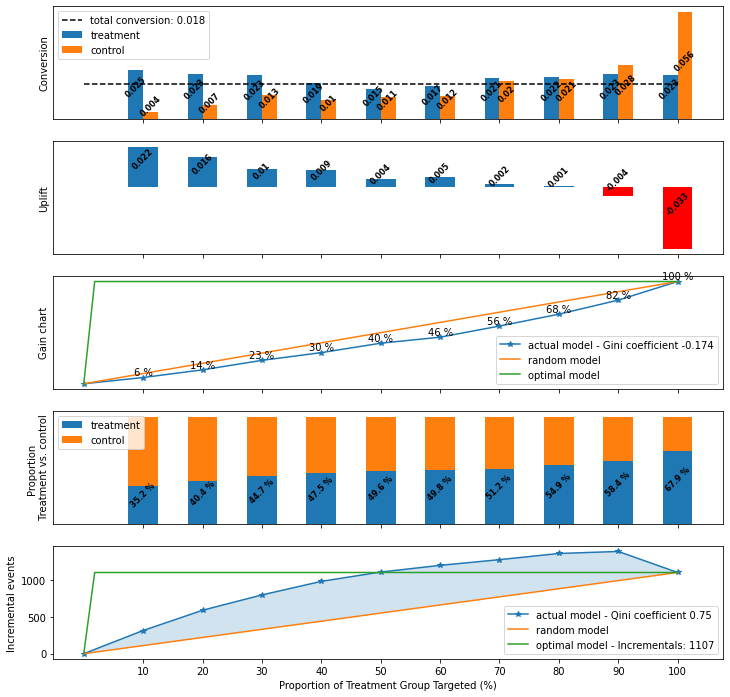

In [50]:
lift, uplift,gini, gain_top30,qini = EvalIncrementalModels(y_test,
                                                           test_treatment,
                                                           y_pred,
                                                           plot = True)

In [ ]:
plot_qini_curve(y_test,y_pred,test_treatment,perfect=True,negative_effect = False)

In [ ]:
classTslearner2 = ClassTransformation(estimator = CatBoostClassifier(iterations=50,
                                                                    thread_count=-1, 
                                                                    random_state=42, 
                                                                    silent=True))
classTslearner2.fit(X = X_train,
                    y = y_train,
                   treatment = train_treatment)
y_pred = classTslearner2.predict(X_test)

In [ ]:
lift, uplift,gini, gain_top30,qini = EvalIncrementalModels(y_test,
                                                           test_treatment,
                                                           y_pred,
                                                           plot = True)

In [ ]:
s_cate = learner_s.predict(X_test[model_vars], treatment=test_treatment, y=y_test)
t_cate = learner_t.predict(X_test[model_vars], treatment=test_treatment, y=y_test)
x_cate = learner_x.predict(X_test[model_vars], treatment=test_treatment, y=y_test)

In [ ]:
set_ = {'S-meta':s_cate[:,0].tolist() ,
        'T-meta':t_cate[:,0].tolist(),
        'X-meta':x_cate[:,0].tolist()}

result = {}
vars_ = ['lift_top10','uplift_top30',
         'gini_coef','gain_top30','qini_coeff']
for key,val in set_.items():
    a,b,c,d,e = EvalIncrementalModels(y_test,
                                      test_treatment,
                                      val,
                                      plot = False)
    
    result[key] = {x:y for x,y in zip(vars_,[a,b,c,d,e])}

In [ ]:
r = pd.DataFrame(result)
# r_normalized = r.apply(lambda x: (x - r.mean(axis = 1))/(r.std(axis = 1)))
r_normalized = r.apply(lambda x: (x - r.min(axis = 1))/(r.max(axis = 1)  - r.min(axis = 1)))
#Por normalizar se puede perder un modelo (el que tenga las variables con valores mas bajos)
categories = r_normalized.index
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

for model in r_normalized .columns:
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)
    # If you want the first axis to be on top:
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories)
    
    values=r_normalized[model].values.tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"{model}")
    ax.fill(angles, values, alpha=0.010)
    ax.legend(loc='upper right', bbox_to_anchor=(0.05, 0.05))
    plt.title('Scaled comparison \n (all variables were scaled [0,1])')

In [ ]:
r

In [ ]:
lift, uplift,gini, gain_top30,qini = EvalIncrementalModels(y_test,
                                                           test_treatment,
                                                           t_cate[:,0].tolist(),
                                                           plot = True)

In [ ]:
lift, uplift,gini, gain_top30,qini = EvalIncrementalModels(y_test,
                                                           test_treatment,
                                                           s_cate[:,0].tolist(),
                                                           plot = True)

In [ ]:
lift, uplift,gini, gain_top30,qini = EvalIncrementalModels(y_test,
                                                           test_treatment,
                                                           x_cate[:,0].tolist(),
                                                           plot = True)

In [ ]:
df_test = X_test
df_test['Y_'] =  t_cate[:,0].tolist()

In [ ]:
df_ = get_qini(df = df_test,outcome_col='Y',treatment_col='W',treatment_effect_col='Y_',normalize= True)

In [ ]:
df_

In [ ]:
plt.plot(df_.CUS_CUST_ID)
plt.plot(df_.Random)

In [ ]:
# import causalml.dataset as data
# dir(data)

In [ ]:
# dataset = make_uplift_classification(n_samples=1000,
#                            treatment_name=['control', 'treatment1'],
#                            y_name='conversion',
#                            n_classification_features=10,
#                            n_classification_informative=5,
#                            n_uplift_increase_dict={'treatment1': 4},
#                            n_uplift_decrease_dict={'treatment1': 3},
#                            delta_uplift_increase_dict={'treatment1': 0.1},
#                            positive_class_proportion=0.1)

In [ ]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)
# tau: individual treatment effect
# b: expected outcome
# e: propensity of receiving treatment
# y: outcome variable
# X: covariates

In [ ]:
# Ready-to-use S-Learner using LinearRegression
learner_s = LRSRegressor()
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

In [ ]:
# XGBTRegressor() vs. BaseTRegressor(learner=XGBRegressor())
# XGBTRegressor() = BaseTRegressor(learner=XGBRegressor()).
# When you use BaseTregressor you can change the model to be used in the Two model approach. 

In [ ]:
# Ready-to-use T-Learner using XGB
learner_t = XGBTRegressor()
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)

# Calling the Base Learner class and feeding in XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using XGB (same result):')
print(ate_t)

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using Linear Regression (different result):')
print(ate_t)

In [ ]:
# S Learner
learner_s = LRSRegressor()
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y)

# T Learner
learner_t = BaseTRegressor(learner=XGBRegressor())
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

# X Learner with propensity score input
learner_x = BaseXRegressor(learner=XGBRegressor())
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=e)

# X Learner without propensity score input
learner_x_no_p = BaseXRegressor(learner=XGBRegressor())
cate_x_no_p = learner_x_no_p.fit_predict(X=X, treatment=treatment, y=y)

In [ ]:
np.subtract(tau , results[:,x]).tolist()

In [ ]:
diff = []
results = np.hstack([cate_s,cate_t,cate_x,cate_x_no_p])
labels = {0: 'single model lr',1:'two model XGBoost-reg',2: 'x model XGBoost-re w/ e', 3:'x model XGBoost-re wo/ e'}
A = []
for x in range(4):
    diff.append(np.subtract(tau , results[:,x]))
    

In [ ]:
results[:,3]

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (16,6))
fig.subplots_adjust(hspace = 5)
axs = axs.ravel()
for x in np.arange(0,3,1):
    y = results[:,x+1]
    axs[x].hist(x = y,bins=100,alpha=0.4)
    axs[x].vlines(x = results[:,0], ymin = 0 , ymax = 1000)
    axs[x].set_title(f'{labels[x+1]} \n mean: {np.round(np.mean(y),2)}')

In [ ]:
fig, axs = plt.subplots(1,4, figsize = (16,6))
fig.subplots_adjust(hspace = 5)
axs = axs.ravel()
for x in range(4):
    y = diff[x]
    axs[x].hist(x = y,bins=100,alpha=0.4)
    axs[x].set_title(f'{labels[x]} - \n MAE: {np.round(np.mean(np.abs(y)),2)}')


In [ ]:
# https://github.com/uber/causalml/blob/master/examples/uplift_trees_with_synthetic_data.ipynb
from causalml.inference.tree import UpliftTreeClassifier

In [ ]:
dataset, x_names = make_uplift_classification(n_samples=1000,
                           treatment_name=['control', 'treatment1'],
                           y_name='conversion',
                           n_classification_features=10,
                           n_classification_informative=5,
                           n_uplift_increase_dict={'treatment1': 4},
                           n_uplift_decrease_dict={'treatment1': 3},
                           delta_uplift_increase_dict={'treatment1': 0.3},#<------------
                           delta_uplift_decrease_dict={'treatment1': 0.1},                    
                           positive_class_proportion=0.1)

In [ ]:
# Split data to training and testing samples for model validation (next section)
df_train, df_test = train_test_split(dataset, test_size=0.2, random_state=111)

In [ ]:
clf = UpliftTreeClassifier(control_name='control')
clf.fit(df_train[x_names].values,
         treatment=df_train['treatment_group_key'].values,
         y=df_train['conversion'].values)
p = clf.predict(df_test[x_names].values,)

In [ ]:
df_res = pd.DataFrame(p, columns=clf.classes_)
df_res.head()

In [ ]:
(df_res.treatment1 - df_res.control ).mean()#<------------

In [ ]:
best_treatment = df_res.idxmax(axis=1)

In [ ]:
best_treatment